# Classification using Logistic Regression
## Goal
 - Tune hyperparameters for Logistic Regression model

##  Conclusion
 - Tuning had little affect on F1 Score
 - Final model has decent accuracy (0.84 for training and 0.83 for test)
 - Final model has decent recall (0.85 for training and 0.82 for test)
 - Precision on final model is not very good (0.47 for training and 0.45 for test)

In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from sklearn.linear_model import LogisticRegression

# Transformers
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from imblearn.over_sampling import SMOTE

# Model Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, f1_score, precision_score, recall_score

# Pipelines
from imblearn.pipeline import Pipeline

### Import Data

In [2]:
df = pd.read_csv('../../data/processed/churn_dataset.csv', index_col = 0)
X = df.drop(columns = 'churn')
y = df.churn

random_state = 45
cv = 5

In [4]:
X

,state,acct_length,intl_plan,vm_plan,no_vm_msg,day_mins,day_calls,eve_mins,eve_calls,night_mins,night_calls,intl_mins,intl_calls,service_calls,city,service_calls_over_3,day_mins_over_225
0,KS,128,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,San_Francisco,0,1
1,OH,107,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,San_Francisco,0,0
2,NJ,137,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,San_Francisco,0,1
3,OH,84,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,San_Jose,0,1
4,OK,75,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,San_Francisco,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,no,yes,36,156.2,77,215.5,126,279.1,83,9.9,6,2,San_Francisco,0,0
3329,WV,68,no,no,0,231.1,57,153.4,55,191.3,123,9.6,4,3,San_Francisco,0,1
3330,RI,28,no,no,0,180.8,109,288.8,58,191.9,91,14.1,6,2,Oakland,0,0
3331,CT,184,yes,no,0,213.8,105,159.6,84,139.2,137,5.0,10,2,Oakland,0,0


### Calculate baseline F1-Score

In [3]:
X_train_all, X_hold_out, y_train_all, y_hold_out = train_test_split(X, y, random_state = random_state)
number_selector = make_column_selector(dtype_include='number')
string_selector = make_column_selector(dtype_include='object')
preprocessing = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), string_selector),
                                        (StandardScaler(), number_selector),
                                        remainder='passthrough')
logreg = LogisticRegression(random_state = random_state, max_iter = 1000)
pipeline = Pipeline([('preprocessing', preprocessing),
                     ('sm', SMOTE(random_state = random_state)), 
                     ('lr', logreg)])
pipeline.fit(X_train_all, y_train_all)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ffa63540d60>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ffa6356d070>)])),
                ('sm', SMOTE(random_state=45)),
                ('lr', LogisticRegression(max_iter=1000, random_state=45))])

In [4]:
train_preds = pipeline.predict(X_train_all)
hold_out_preds = pipeline.predict(X_hold_out)

train_f1 = f1_score(y_train_all, train_preds)
test_f1 = f1_score(y_hold_out, hold_out_preds)
print('Baseline Training F1-Score: {:.2f}'.format(train_f1))
print('Baseline Testing F1-Score: {:.2f}'.format(test_f1))

Baseline Training F1-Score: 0.61
Baseline Testing F1-Score: 0.57


### Tune Hyperparameters
***First Round:***
- Try C between 1.0-9.0 in increments of 2.0.

In [5]:
param_grid = {'lr__fit_intercept':(True, False), 
              'lr__C':np.arange(1.0, 10, 2), 
              'lr__solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
              'lr__class_weight':('balanced', None)}
grid_search = GridSearchCV(pipeline, param_grid, scoring = 'f1')
grid_search.fit(X_train_all, y_train_all)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ffa63540d60>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ffa6356d070>)])),
                                       ('sm', SMOTE(random_state=45)),
                                       ('lr',
                                     

In [6]:
print('Training F1-Score: {:.2f}'.format(grid_search.score(X_train_all, y_train_all)))
print('Test F1-Score: {:.2f}'.format(grid_search.score(X_hold_out, y_hold_out)))

Training F1-Score: 0.61
Test F1-Score: 0.57


In [7]:
grid_search.best_params_

{'lr__C': 1.0,
 'lr__class_weight': 'balanced',
 'lr__fit_intercept': True,
 'lr__solver': 'liblinear'}

***Second Round:***
- First round selected lowest value for C (i.e., 1.0).
- Try C between 0.1-1.0 in increments of 0.1.

In [8]:
param_grid = {'lr__fit_intercept':(True, False), 
              'lr__C':np.arange(0.1, 1.1, .1), 
              'lr__solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
              'lr__class_weight':('balanced', None)}
grid_search = GridSearchCV(pipeline, param_grid, scoring = 'f1')
grid_search.fit(X_train_all, y_train_all)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ffa63540d60>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ffa6356d070>)])),
                                       ('sm', SMOTE(random_state=45)),
                                       ('lr',
                                     

In [9]:
print('Training F1-Score: {:.2f}'.format(grid_search.score(X_train_all, y_train_all)))
print('Test F1-Score: {:.2f}'.format(grid_search.score(X_hold_out, y_hold_out)))

Training F1-Score: 0.61
Test F1-Score: 0.59


In [10]:
grid_search.best_params_

{'lr__C': 0.2,
 'lr__class_weight': 'balanced',
 'lr__fit_intercept': True,
 'lr__solver': 'saga'}

***Third Round:***
- Second round selected C = 0.2.
- Try C between 0.12 - 0.28 in increments of 0.02

In [11]:
param_grid = {'lr__fit_intercept':(True, False), 
              'lr__C':np.arange(0.12, 0.3, .02),
              'lr__solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
              'lr__class_weight':('balanced', None)}
grid_search = GridSearchCV(pipeline, param_grid, scoring = 'f1')
grid_search.fit(X_train_all, y_train_all)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ffa63540d60>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ffa6356d070>)])),
                                       ('sm', SMOTE(random_state=45)),
                                       ('lr',
                                     

In [12]:
print('Training F1-Score: {:.2f}'.format(grid_search.score(X_train_all, y_train_all)))
print('Test F1-Score: {:.2f}'.format(grid_search.score(X_hold_out, y_hold_out)))

Training F1-Score: 0.61
Test F1-Score: 0.59


In [13]:
grid_search.best_params_

{'lr__C': 0.21999999999999995,
 'lr__class_weight': 'balanced',
 'lr__fit_intercept': True,
 'lr__solver': 'newton-cg'}

### Instantiate Final Model

In [14]:
logreg = LogisticRegression(random_state = random_state, max_iter = 1000, 
                            C = 0.22, fit_intercept = True, class_weight = 'balanced', 
                            solver = 'newton-cg')
pipeline = Pipeline([('preprocessing', preprocessing),
                     ('sm', SMOTE(random_state = random_state)), 
                     ('lr', logreg)])
pipeline.fit(X_train_all, y_train_all)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ffa63540d60>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ffa6356d070>)])),
                ('sm', SMOTE(random_state=45)),
                ('lr',
                 LogisticRegression(C=0.22, class_weight='balanced',
                                    max_iter=1000, random_state=45,
                                    solver='newton-cg'))])

In [15]:
train_preds = pipeline.predict(X_train_all)
hold_out_preds = pipeline.predict(X_hold_out)

train_f1 = f1_score(y_train_all, train_preds)
test_f1 = f1_score(y_hold_out, hold_out_preds)
print('Training F1-Score: {:.2f}'.format(train_f1))
print('Testing F1-Score: {:.2f}'.format(test_f1))

Training F1-Score: 0.61
Testing F1-Score: 0.59


### Check Confusion Matrices and Calculate Accuracy

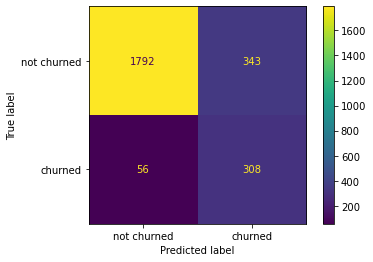

In [16]:
plot_confusion_matrix(pipeline, X_train_all, y_train_all, display_labels=['not churned', 'churned'])

In [17]:
print('Training Accuracy: {:.2f}'.format(pipeline.score(X_train_all, y_train_all)))
print('Training Recall: {:.2f}'.format(recall_score(y_train_all, train_preds)))
print('Training Precision: {:.2f}'.format(precision_score(y_train_all, train_preds)))

Training Accuracy: 0.84
Training Recall: 0.85
Training Precision: 0.47


***Notes***
- Training accuracy is decent
- Training recall is decent
- Training precision is not very good

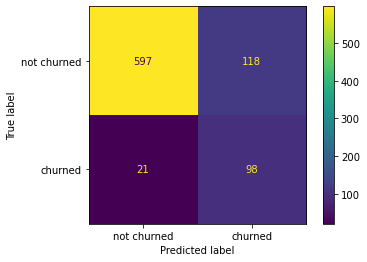

In [18]:
plot_confusion_matrix(pipeline, X_hold_out, y_hold_out, display_labels=['not churned', 'churned'])

In [19]:
print('Test Accuracy: {:.2f}'.format(pipeline.score(X_hold_out, y_hold_out)))
print('Test Recall: {:.2f}'.format(recall_score(y_hold_out, hold_out_preds)))
print('Test Precision: {:.2f}'.format(precision_score(y_hold_out, hold_out_preds)))

Test Accuracy: 0.83
Test Recall: 0.82
Test Precision: 0.45


***Notes***
- Test accuracy is decent
- Test recall is decent
- Test precision is not very good